# Model evaluation 
### A systematic way of evaluating different models
### Introduction to some common metrics

In [1]:
# Set up utility functions for model evaluation

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import model_selection


In [2]:
# Preprocess the data (credit card transaction - detect fraud)

def get_train_test_data():
    df = pd.read_csv('C:/dev/research/temp/handson-unsupervised-learning/datasets/credit_card_data/credit_card.csv',  header=0, index_col=0)
    dataX = df.copy().drop(['Class'], axis=1)
    dataY = df['Class'].copy()

    # We need to standardize the featurs - mean 0 and std 1
    features = dataX.columns
    ss = preprocessing.StandardScaler()
    dataX.loc[:, features] = ss.fit_transform(dataX[features])
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(dataX, dataY, test_size=0.33, random_state=2018, stratify=dataY)
    return X_train, X_test, y_train, y_test


In [3]:
# Metrics to evaluate model performance
# 1. CV Log loss
# 2. Precision Recall Average
# 3. ROC AUC

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

def get_evaluation_report(model, X_train, X_test, y_train, y_test):
    
    # train model
    model.fit(X_train, y_train)
    
    # precision recall
    precision, recall, average_precision = find_precision_recall(X_test, y_test, model)
    
    # ROC 
    fpr, tpr, roc_area = find_roc_data(X_test, y_test, model)
    
    # Logloss on CV folds
    splits = 10
    loss_train_avg, loss_train_std, loss_test_avg, loss_test_std = find_cv_log_loss(X_train, y_train, model, splits)
    
    print("**** Performance report ****")
    # print("Features importance: " % model.feature_importances_) << only for forest
    
    print("** Precision Recall **")
    plot_precision_recall_curve(precision, recall, average_precision)
    
    print("** ROC **")
    plot_roc_curve(fpr, tpr, roc_area)
    
    print("** Log loss **")
    print("CV Training data Logloss %.5f%% (%.5f%%) on %3d splits" % (loss_train_avg*100, loss_train_std*100, splits))
    print("CV Test data Logloss %.5f%% (%.5f%%) on %3d splits" % (loss_test_avg*100, loss_test_std*100, splits))
    
    print("Test data Logloss: ", find_log_loss(X_test, y_test, model))
    
def find_log_loss(X_data, y_data, model):
    y_proba = model.predict_proba(X_data)
    return log_loss(y_data, y_proba[:,1])
    
def find_cv_log_loss(X_data, y_data, model, splits=10):
    # We will do a CV to get the average training log loss 
    logloss_train_list = []
    logloss_test_list = []
    
    seed = 2018
    kfold = model_selection.StratifiedKFold(n_splits=splits, random_state=seed)
    for train_index, test_index in kfold.split(X_data, y_data.ravel()):
        X_train_fold, X_test_fold = X_data.iloc[train_index,:], X_data.iloc[test_index,:]
        y_train_fold, y_test_fold = y_data.iloc[train_index], y_data.iloc[test_index]
        model.fit(X_train_fold, y_train_fold)
        logloss_train_list.append(find_log_loss(X_train_fold, y_train_fold, model))
        logloss_test_list.append(find_log_loss(X_test_fold, y_test_fold, model))
        
    return np.mean(logloss_train_list), np.std(logloss_train_list), np.mean(logloss_test_list), np.std(logloss_test_list)
    
def find_precision_recall(X_data, y_data, model):
    y_proba = model.predict_proba(X_data)
    precision, recall, thresholds = precision_recall_curve(y_data.values, y_proba[:,1])
    average_precision = average_precision_score(y_data.values, y_proba[:,1])
    return precision, recall, average_precision

def find_roc_data(X_data, y_data, model):
    y_proba = model.predict_proba(X_data)
    fpr, tpr, thresholds = roc_curve(y_data.values, y_proba[:,1])
    roc_area = roc_auc_score(y_data.values, y_proba[:,1])
    return fpr, tpr, roc_area

def plot_precision_recall_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()
    
def plot_roc_curve(fpr, tpr, roc_area):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_area)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Let's test a few classifiers

In [4]:
# This step is time consuming, shall be ran once to save time
X_train, X_test, y_train, y_test = get_train_test_data()

**** Performance report ****
** Precision Recall **


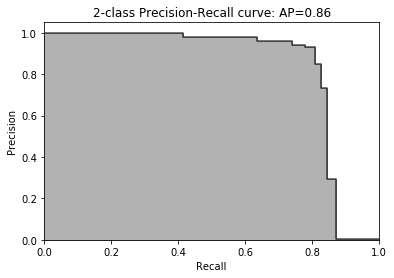

** ROC **


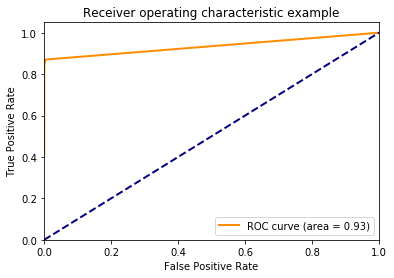

** Log loss **
CV Training data Logloss 0.04539% (0.00153%) on  10 splits
CV Test data Logloss 1.09215% (0.38425%) on  10 splits
Test data Logloss:  0.00997419995447


In [6]:
## Random forest

from sklearn.ensemble import RandomForestClassifier

# start with mostly default parameters
model = RandomForestClassifier(n_estimators=8)

# get performance report
get_evaluation_report(model, X_train, X_test, y_train, y_test)


In [5]:
## XGBoost
import xgboost as xgb

## LightGBM
import lightgbm as lgb

In [8]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

params = {'objective':'binary:logistic',
    'num_class':1,
    'eval_metric':'logloss',
    'silent':1}

cv_history = xgb.cv(params, dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=200, verbose_eval=100, stratified=True)

[0]	train-logloss:0.43794+2.41959e-05	test-logloss:0.43805+8.80668e-05
[100]	train-logloss:5.56e-05+1.49666e-06	test-logloss:0.0033626+0.000758129
[200]	train-logloss:3.3e-05+8.94427e-07	test-logloss:0.0035368+0.000817394


In [15]:
cv_history

,test-logloss-mean,test-logloss-std,train-logloss-mean,train-logloss-std
0,0.438050,0.000088,0.437940,0.000024
1,0.297152,0.000104,0.296980,0.000020
2,0.208396,0.000123,0.208168,0.000028
3,0.149040,0.000129,0.148754,0.000037
4,0.107985,0.000133,0.107661,0.000043
5,0.079003,0.000161,0.078640,0.000048
6,0.058260,0.000182,0.057859,0.000052
7,0.043277,0.000200,0.042845,0.000054
8,0.032381,0.000219,0.031910,0.000056
9,0.024423,0.000245,0.023907,0.000053


In [17]:
cv_history.shape

(30, 4)

In [16]:
np.argmin(cv_history['test-logloss-mean'])

29

In [11]:
def gbm_evaluation(y_test, prediction):
    # metrics calculation is a little bit different
    precision, recall, thresholds = precision_recall_curve(y_test.values, prediction)
    average_precision = average_precision_score(y_test.values, prediction)
    plot_precision_recall_curve(precision, recall, average_precision)

    fpr, tpr, thresholds = roc_curve(y_test.values, prediction)
    roc_area = roc_auc_score(y_test.values, prediction)
    plot_roc_curve(fpr, tpr, roc_area)



In [ ]:
round_with_min_loss = np.argmin(cv_history['test-logloss-mean'])
model = xgb.train(params, dtrain, round_with_min_loss)
prediction = model.predict(dtest) # this is the predict probability it seems to be

gbm_evaluation(y_test, prediction)

In [8]:
np.amin(prediction)

8.6400054e-05

In [19]:
y = np.where(prediction > 0.6)
type(y)

tuple

In [20]:
np.size(y)

137

In [ ]:
#### light GBM performance

In [6]:
params_lgb = {'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0}

[1]	valid_0's binary_logloss: 0.00581772
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00575686
[3]	valid_0's binary_logloss: 0.00569619
[4]	valid_0's binary_logloss: 0.00563637
[5]	valid_0's binary_logloss: 0.00558271
[6]	valid_0's binary_logloss: 0.00552866
[7]	valid_0's binary_logloss: 0.00547923
[8]	valid_0's binary_logloss: 0.00542943
[9]	valid_0's binary_logloss: 0.00538059
[10]	valid_0's binary_logloss: 0.00533507
[11]	valid_0's binary_logloss: 0.00528279
[12]	valid_0's binary_logloss: 0.00523537
[13]	valid_0's binary_logloss: 0.00519597
[14]	valid_0's binary_logloss: 0.0051555
[15]	valid_0's binary_logloss: 0.00511739
[16]	valid_0's binary_logloss: 0.00507796
[17]	valid_0's binary_logloss: 0.00503826
[18]	valid_0's binary_logloss: 0.00499996
[19]	valid_0's binary_logloss: 0.00496491
[20]	valid_0's binary_logloss: 0.00492731
[21]	valid_0's binary_logloss: 0.00489326
[22]	valid_0's binary_logloss: 0.00485903
[23]	valid_0's binary_l

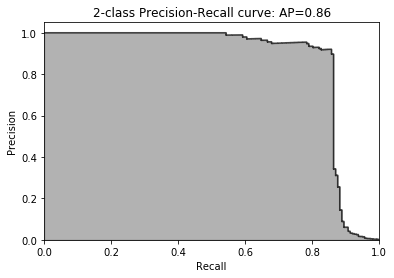

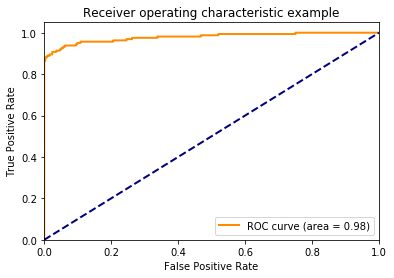

0.00248685956872


In [12]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) # should use CV or split a validation set from training.
model = lgb.train(params_lgb, lgb_train, num_boost_round=2000, valid_sets=lgb_eval, early_stopping_rounds=200)
prediction = model.predict(X_test, num_iteration=model.best_iteration)

gbm_evaluation(y_test, prediction)

loglossTest = log_loss(y_test, model.predict(X_test, num_iteration=model.best_iteration))
print(loglossTest)